In [330]:
#Questions: Are the different coefficients uniform amongst all the nodes in the graph ? Right now, they are equal for all nodes. 
# Yes they should be equal since we are assuming that the effect is shared and we just variate over the value of the feature.
#To easily compute and update the happiness, we keep the following properties true during the evolution of the graph:
# - the attribute contains the happiness of the current node at each step
# - at the begining of a step, the attribute 'happiness_updating' contains coeff_X*X + coeff_Z*Z + coeff_previous_happiness*happiness.
#Therefore we only have to add the influence of all the other nodes at 'happiness_updating' to obtain the updated happiness.

#Here, at each step, we choose a random node and add one friend to it. Then update the happiness of everyone.

In [331]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

In [332]:
#Defining our global variables:
N_nodes = 100
#This is the rate of updated nodes for each run (only 30% of the nodes will have a new friend per run here for instance)
rate_updated_nodes_per_run = 0.3

In [333]:
#Defining graph
G=nx.DiGraph()
G.add_nodes_from(range(N_nodes))

In [334]:
#Defining attributes
for i in range(N_nodes):
    G.node[i]['X'] = random.random()*2.0-1.0
    G.node[i]['Z'] = 0*random.random()*2.0-1.0
    G.node[i]['coeff_X'] = 0.5
    G.node[i]['coeff_Z'] = 0.0
    G.node[i]['coeff_previous_happiness'] = 0.1
    G.node[i]['coeff_influence'] = 0.7
    G.node[i]['happiness'] = [G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']]
    G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness'][0]

In [335]:
#Creating similarity matrices
similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
similarity_coefficient = 3
for i in range(N_nodes):
    for j in range(i):
        similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
        observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
        similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
        similarity_matrix[j][i] = similarity_matrix[i][j]
        observable_matrix[j][i] = observable_matrix[i][j]
        


In [336]:
#Creating set of potential friends for each node
def create_list_potential_friends(Graph):
    list_potential_friends = [[] for i in range(N_nodes)]
    for i in range(N_nodes):
        for j in range(N_nodes):
            if i != j and (i,j) not in Graph.edges():
                if random.random() < similarity_matrix[i][j]:
                    list_potential_friends[i].append(j)
    return list_potential_friends

global list_potential_friends
list_potential_friends = create_list_potential_friends(G)

In [337]:
#Function to add to the node "node" a random friend from his list of friends (and to remove him from the list)
def add_one_friend(node, Graph, idx_step):
    if len(list_potential_friends[node])>0:
        new_friend = random.choice(list_potential_friends[node])
        Graph.add_edge(node, new_friend, step_creation = idx_step)

In [338]:
#This step is made to add a friend for each node of the Graph
def init_step(Graph, idx_step):   
    global list_potential_friends
    for node in range(N_nodes):
        add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [339]:
#Update happiness 
def update_happiness(Graph):
    for (a,b) in Graph.edges_iter():
        Graph.node[a]['happiness_updating'] +=  Graph.node[a]['coeff_influence'] *Graph.node[b]['happiness'][-1]/len(Graph.neighbors(a))
    for i in range(N_nodes):
        Graph.node[i]['happiness'].append(Graph.node[i]['happiness_updating'])
        Graph.node[i]['happiness_updating'] = Graph.node[i]['coeff_previous_happiness']*Graph.node[i]['happiness'][-1] + Graph.node[i]['X'] * Graph.node[i]['coeff_X'] + Graph.node[i]['Z'] * Graph.node[i]['coeff_Z']

In [340]:
def run_step(Graph, idx_step):
    global list_potential_friends
    for node in range(N_nodes):
        if random.random() < rate_updated_nodes_per_run:
            add_one_friend(node, Graph, idx_step)
    update_happiness(Graph)
    list_potential_friends = create_list_potential_friends(Graph)

In [341]:
def compute_real_effect(Graph):
    matrix_res = [[0. for j in range(N_nodes)] for i in range(N_nodes)]
    for i in range(N_nodes):
        if Graph.out_degree(i) ==1:
            for k in nx.all_neighbors(Graph,i):
                new_friend=k
                new_additional_happiness_no_new_friend = Graph.node[k]['happiness'][-1]*G.node[i]['coeff_influence']/2.
            for j in nx.non_neighbors(Graph,i): 
                if Graph.node[j]['happiness'][-1] > Graph.node[i]['happiness'][-1]:
                    new_additional_happiness_with_new_friend_j = Graph.node[j]['happiness'][-1]*Graph.node[i]['coeff_influence']/2.
                    matrix_res[i][j] = new_additional_happiness_with_new_friend_j - new_additional_happiness_no_new_friend
        else:
            print "special case: node without " + str(Graph.out_degree(i)) + " friends" 
#     return matrix_res
    res=0.
    count_friends_potentially_added=0
    for i in range(N_nodes):
        for j in range(N_nodes):
            if matrix_res[i][j] >0:
                count_friends_potentially_added += 1.
                res += matrix_res[i][j]
    return res /count_friends_potentially_added

In [342]:
#Main run for the graph
nb_steps=1
init_step(G, 0)
print compute_real_effect(G)
for i in range(nb_steps):
    run_step(G, i+1)

0.20337010449


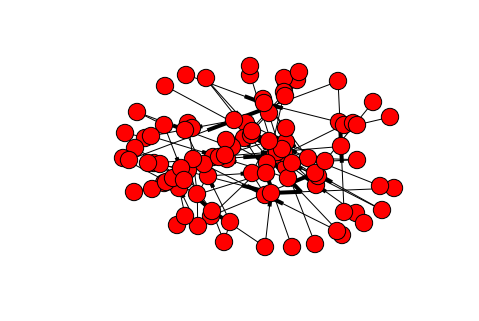

In [343]:
#Plotting the last graph obtained
nx.draw(G)
plt.show()

In [344]:
def create_propensity_table(Graph):
    edges = []
    treatment = []
    response = []
    friends = []
    X1 = []
    X2 = []
    second_friend_happiness = []
    for i in range(N_nodes):
        for j in range(i+1,N_nodes):
            if Graph.node[j]['happiness'][-2]> Graph.node[i]['happiness'][-2]:
                u,v = i,j
            else:
                u,v = j,i
                
            if (u,v) in Graph.edges() and Graph[u][v]['step_creation']==1:
                treatment.append(1)
                second_friend_happiness.append(Graph.node[v]['happiness'][-2])
                edges.append((u,v))
                response.append(Graph.node[u]['happiness'][-1]-Graph.node[u]['happiness'][-2])
                friends.append(sum([Graph.node[w]['happiness'][-2] for w in Graph.neighbors(u) if Graph[u][w]['step_creation']<1 ]))                    
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
            elif len(Graph.neighbors(u))==1 :
                edges.append((u,v))
                treatment.append(0)
                second_friend_happiness.append(0)
                response.append(Graph.node[u]['happiness'][-1]-Graph.node[u]['happiness'][-2])
                friends.append(sum([Graph.node[w]['happiness'][-2] for w in Graph.neighbors(u) ]))                    
                X1.append(Graph.node[u]['X'])
                X2.append(Graph.node[v]['X'])
                
            
                
    return pd.DataFrame({'Edges':edges,
                    'Treatment': treatment,
                    'Response': response,
                    'Friends': friends,
                    'Second':second_friend_happiness,
                    'X1': X1,
                    'X2': X2})

In [345]:
data = create_propensity_table(G)
data['X3'] = abs(data['X2']-data['X1'])
data

,Edges,Friends,Response,Second,Treatment,X1,X2,X3
0,"(0, 1)",-0.243679,-0.058238,0,0,-0.625977,0.076117,0.702094
1,"(0, 2)",-0.243679,-0.058238,0,0,-0.625977,-0.033811,0.592166
2,"(0, 3)",-0.243679,-0.058238,0,0,-0.625977,0.352112,0.978089
3,"(0, 4)",-0.243679,-0.058238,0,0,-0.625977,0.776765,1.402742
4,"(0, 5)",-0.243679,-0.058238,0,0,-0.625977,0.397193,1.023170
5,"(0, 6)",-0.243679,-0.058238,0,0,-0.625977,-0.017448,0.608528
6,"(0, 7)",-0.243679,-0.058238,0,0,-0.625977,0.016508,0.642485
7,"(0, 8)",-0.243679,-0.058238,0,0,-0.625977,0.331010,0.956987
8,"(0, 9)",-0.243679,-0.058238,0,0,-0.625977,0.382751,1.008728
9,"(10, 0)",-0.558863,-0.172351,0,0,-0.470786,-0.625977,0.155191


In [346]:
propensity = LogisticRegression()
propensity = propensity.fit(data[['X1','X2','X3']], data.Treatment)
pscore = propensity.predict_proba(data[['X1','X2','X3']])[:,1] # The predicted propensities by the model
data['Propensity'] = pscore


In [347]:
def Match(groups, propensity, caliper = 0.05):
    ''' 
    Inputs:
    groups = Treatment assignments.  Must be 2 groups
    propensity = Propensity scores for each observation. Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. For now, this is a caliper on the raw
            propensity; Austin reccommends using a caliper on the logit propensity.
    
    Output:
    A series containing the individuals in the control group matched to the treatment group.
    Note that with caliper matching, not every treated individual may have a match.
    '''

    # Check inputs
    if any(propensity <=0) or any(propensity >=1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0<caliper<1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
        
        
    # Code groups as 0 and 1
    groups = groups == groups.unique()[0]
    N = len(groups)
    N1 = groups.sum(); N2 = N-N1
    g1, g2 = propensity[groups == 1].reset_index(drop=True), (propensity[groups == 0]).reset_index(drop=True)
    # Check if treatment groups got flipped - treatment (coded 1) should be the smaller
    if N1 > N2:
        N1, N2, g1, g2 = N2, N1, g2, g1 
        
        
    # Randomly permute the smaller group to get order for matching
    morder = np.random.permutation(N1)
    matches = pd.Series(np.empty(N1))
    matches[:] = np.NAN
    
    for m in morder:
        dist = abs(g1[m] - g2)
        if dist.min() <= caliper:
            matches[m] = int(dist.argmin())
            g2 = g2.drop(matches[m])
    return (matches)


In [348]:
stuff = Match(data.Treatment, data.Propensity)
g1, g2 = data.Propensity[data.Treatment==1].reset_index(drop=True), data.Propensity[data.Treatment==0].reset_index(drop=True)


In [349]:
# zip(g1, g2[stuff])

In [350]:
r1 = data[data.Treatment==1].reset_index(drop=True)
r2 = data[data.Treatment==0].reset_index(drop=True)
st=[int(x) for x in stuff if not math.isnan(g2[stuff][x])]
data2 = pd.concat([r1,r2.iloc[stuff]]).reset_index(drop=True)

print data2

       Edges   Friends  Response    Second  Treatment        X1        X2  \
0    (44, 1) -0.747766 -0.051952 -0.081809          1 -0.352954  0.076117   
1    (87, 1)  0.079108 -0.033461 -0.081809          1 -0.493224  0.076117   
2    (59, 2) -0.243679  0.019102 -0.019541          1 -0.847617 -0.033811   
3    (68, 2) -0.558863  0.015701 -0.019541          1 -0.612870 -0.033811   
4    (83, 2) -0.660629  0.012996 -0.019541          1 -0.890340 -0.033811   
5    (3, 13) -0.501926  0.323753  0.712064          1  0.352112  0.832922   
6    (52, 5)  0.020870  0.179935  0.450415          1  0.725590  0.397193   
7    (6, 56) -0.660629  0.048168  0.068479          1 -0.017448  0.095457   
8   (30, 12) -0.236322  0.184252  0.579628          1  0.554874  0.843227   
9   (96, 12) -0.030951  0.165116  0.579628          1  0.513387  0.843227   
10  (15, 78) -0.392010 -0.203195 -0.704619          1 -0.973538 -0.920376   
11  (16, 94) -0.698246 -0.058167 -0.135653          1 -0.644217 -0.235538   

In [351]:
# result = sm.ols(formula="Response ~ Treatment +Friends+Previous+X1", data=data2).fit()

In [352]:
# result.params

In [353]:
#Defining the empty list for distribution response:
distribution_response = []
distribution_estimation = []

In [354]:
#Global loop for real response:
nb_total_steps = 100
for nb_total_step in range(nb_total_steps):
    if nb_total_step %10 ==0:
        print str(nb_total_step+1) + " out of " + str(nb_total_steps)
    G=nx.DiGraph()
    G.add_nodes_from(range(N_nodes))
    #Defining attributes
    for i in range(N_nodes):
        G.node[i]['X'] = random.random()*2.0-1.0
        G.node[i]['Z'] = 0*random.random()*2.0-1.0
        G.node[i]['coeff_X'] = 0.5
        G.node[i]['coeff_Z'] = 0.0
        G.node[i]['coeff_previous_happiness'] = 0.1
        G.node[i]['coeff_influence'] = 0.7
        G.node[i]['happiness'] = [G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']]
        G.node[i]['happiness_updating'] = G.node[i]['X'] * G.node[i]['coeff_X'] + G.node[i]['Z'] * G.node[i]['coeff_Z']+ G.node[i]['coeff_previous_happiness']* G.node[i]['happiness'][0]
    #Creating similarity matrices
    similarity_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
    observable_matrix = [[0 for i in range(N_nodes)] for j in range(N_nodes)]
    similarity_coefficient = 3
    for i in range(N_nodes):
        for j in range(i):
            similarity_matrix[i][j] = -similarity_coefficient*math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2 + (G.node[i]['Z'] - G.node[j]['Z'])**2)
            observable_matrix[i][j] = math.sqrt((G.node[i]['X'] - G.node[j]['X'])**2) 
            similarity_matrix[i][j] = 1.0 / (1.0 + math.exp(-similarity_matrix[i][j]))
            similarity_matrix[j][i] = similarity_matrix[i][j]
            observable_matrix[j][i] = observable_matrix[i][j]
    global list_potential_friends
    list_potential_friends = create_list_potential_friends(G)
    init_step(G, 0)
    distribution_response.append(compute_real_effect(G))
    run_step(G, 1)
    data = create_propensity_table(G)
    data['X3'] = abs(data['X2']-data['X1'])
    propensity = LogisticRegression()
    propensity = propensity.fit(data[['X1','X2','X3']], data.Treatment)
    pscore = propensity.predict_proba(data[['X1','X2','X3']])[:,1] # The predicted propensities by the model
    data['Propensity'] = pscore
    stuff = Match(data.Treatment, data.Propensity)
    g1, g2 = data.Propensity[data.Treatment==1].reset_index(drop=True), data.Propensity[data.Treatment==0].reset_index(drop=True)
    r1 = data[data.Treatment==1].reset_index(drop=True)
    r2 = data[data.Treatment==0].reset_index(drop=True)
    st=[int(x) for x in stuff if not math.isnan(g2[stuff][x])]
    data2 = pd.concat([r1,r2.iloc[stuff]]).reset_index(drop=True)
    result = sm.ols(formula="Response ~ Treatment ", data=data2).fit()
    distribution_estimation.append(result.params.Treatment)
    

1 out of 100
11 out of 100
21 out of 100
31 out of 100
41 out of 100
51 out of 100
61 out of 100
71 out of 100
81 out of 100
91 out of 100


(array([ 1.,  0.,  0.,  1.,  5.,  2.,  1.,  2.,  5.,  5.,  4.,  7.,  9.,
         6.,  5.,  5.,  6.,  6.,  6.,  6.,  2.,  3.,  4.,  2.,  2.,  1.,
         0.,  1.,  0.,  3.]),
 array([ 0.16439004,  0.16714218,  0.16989432,  0.17264646,  0.1753986 ,
         0.17815074,  0.18090288,  0.18365502,  0.18640716,  0.1891593 ,
         0.19191144,  0.19466358,  0.19741573,  0.20016787,  0.20292001,
         0.20567215,  0.20842429,  0.21117643,  0.21392857,  0.21668071,
         0.21943285,  0.22218499,  0.22493713,  0.22768927,  0.23044141,
         0.23319355,  0.2359457 ,  0.23869784,  0.24144998,  0.24420212,
         0.24695426]),
 <a list of 30 Patch objects>)

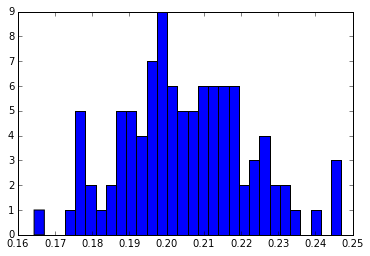

In [355]:
import matplotlib.pyplot as plt
#Doing stuff with the previous distribution
plt.hist(distribution_response, 30)

(array([  1.,   0.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,   4.,   1.,
          3.,   4.,   9.,   9.,   8.,  11.,   7.,   8.,   7.,   5.,   5.,
          6.,   4.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([-0.08540396, -0.07360961, -0.06181525, -0.0500209 , -0.03822655,
        -0.02643219, -0.01463784, -0.00284349,  0.00895086,  0.02074522,
         0.03253957,  0.04433392,  0.05612827,  0.06792263,  0.07971698,
         0.09151133,  0.10330568,  0.11510004,  0.12689439,  0.13868874,
         0.15048309,  0.16227745,  0.1740718 ,  0.18586615,  0.1976605 ,
         0.20945486,  0.22124921,  0.23304356,  0.24483791,  0.25663227,
         0.26842662]),
 <a list of 30 Patch objects>)

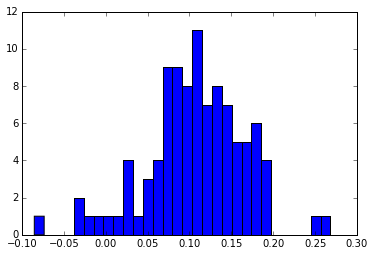

In [356]:
plt.hist(distribution_estimation, 30)

In [357]:
print np.mean(distribution_response)
print np.mean(distribution_estimation)

0.205084193081
0.107009766608
